### Final Project


Checking for NaN values in the data:
bigPlay             0
yardsGained         0
speed_max           0
speed_mean          0
acc_max             0
acc_mean            0
dist_min            0
dist_mean           0
x_range             0
y_range             0
time_to_snap        0
position            0
playAction          0
dropbackType        0
offenseFormation    0
dtype: int64

Data shape after filling NaN values: (2574, 25)
Accuracy: 0.9009708737864077
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       434
        True       0.88      0.43      0.58        81

    accuracy                           0.90       515
   macro avg       0.89      0.71      0.76       515
weighted avg       0.90      0.90      0.89       515



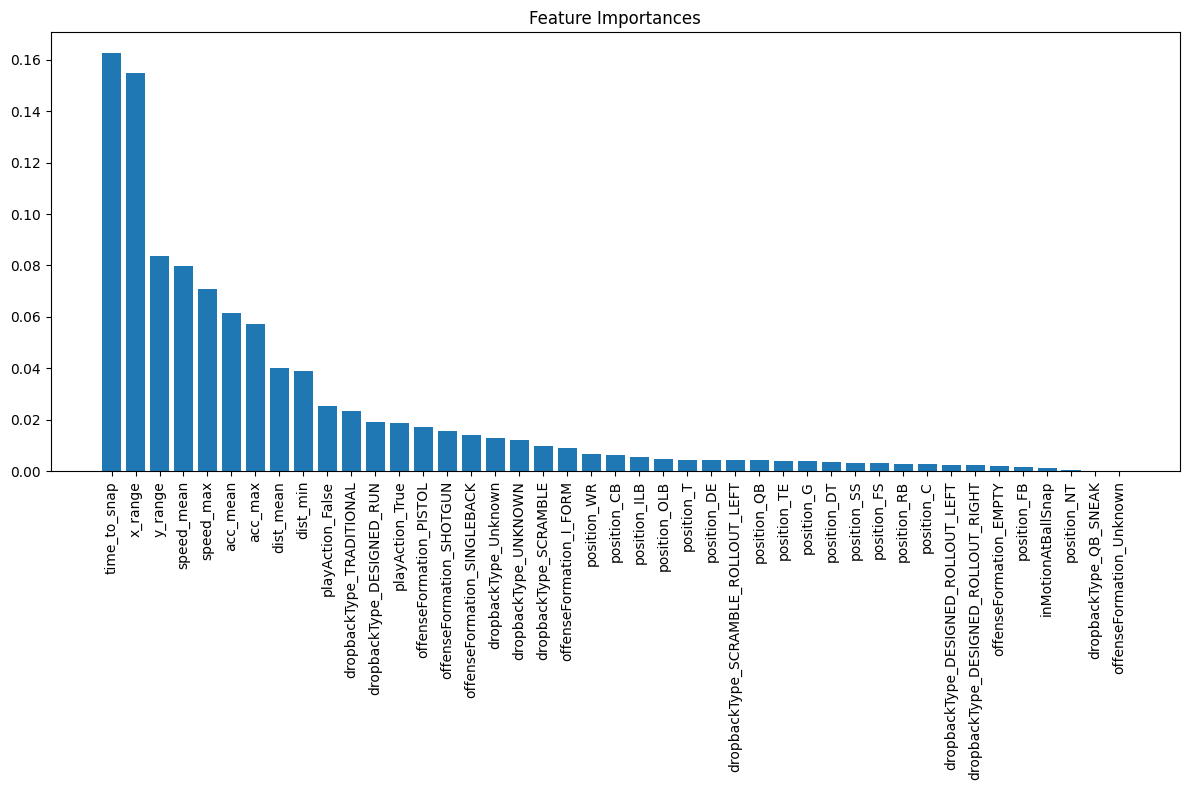


Average Pre-snap Metrics by Offensive Formation:
                  speed_max  speed_mean   acc_max  acc_mean  dist_min  \
offenseFormation                                                        
EMPTY              4.931705    1.373986  4.236818  0.996990  5.410040   
I_FORM             5.214021    1.530742  4.393182  1.068145  5.315894   
PISTOL             4.645420    1.362862  4.223636  1.024466  5.410702   
SHOTGUN            4.788935    1.472326  4.292938  1.057856  5.422631   
SINGLEBACK         4.702778    1.469402  4.126313  1.004462  5.392109   
Unknown            0.808182    0.356468  1.415682  0.468773  5.963703   

                  dist_mean    x_range    y_range  time_to_snap  
offenseFormation                                                 
EMPTY              8.245798  10.015227  10.319659     20.460417  
I_FORM             8.050946   9.259545  14.041783     19.181410  
PISTOL             8.200748   8.540979  10.696958     19.417308  
SHOTGUN            8.131445  10.127

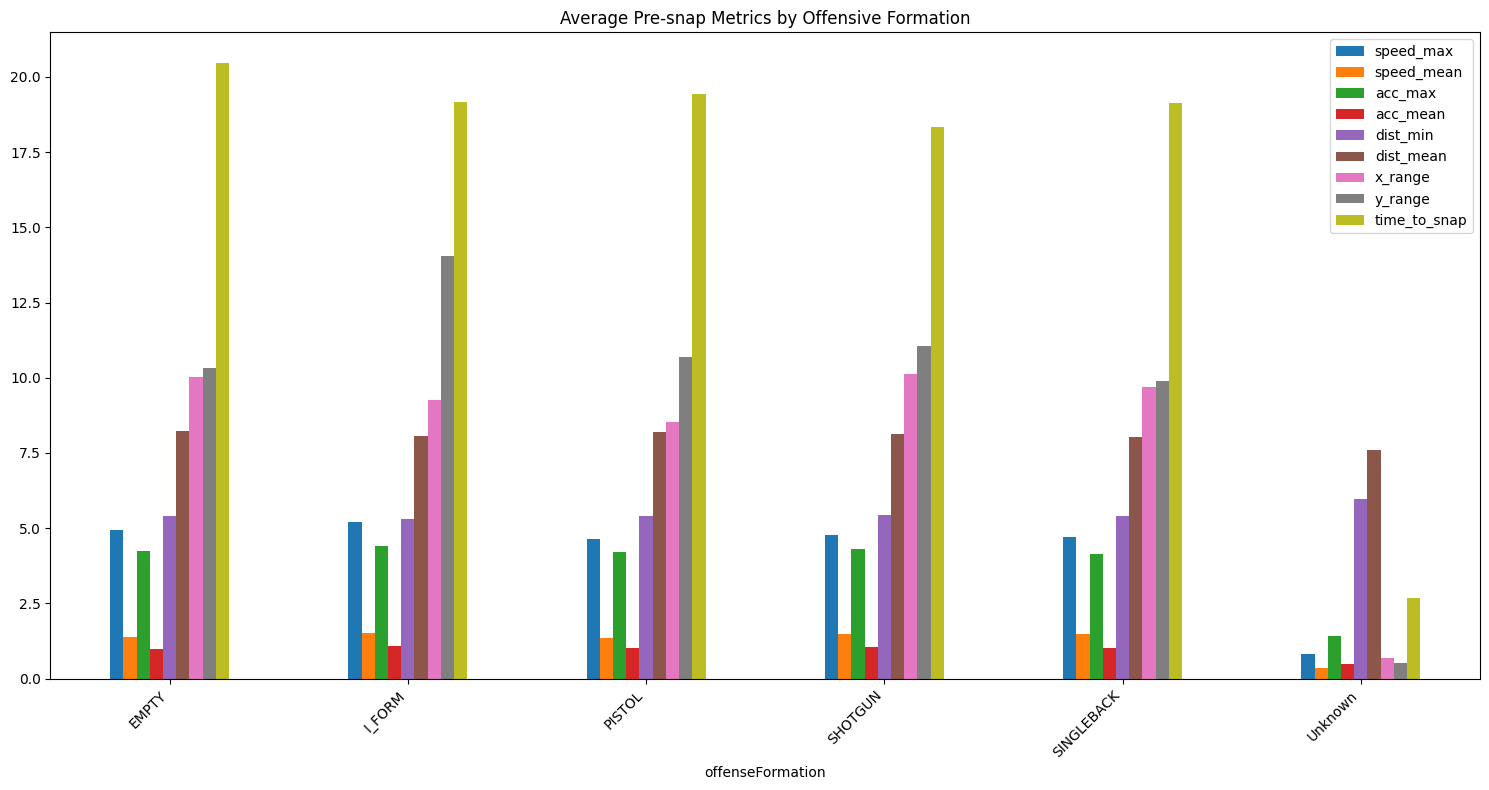

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load necessary datasets
games = pd.read_csv("../nfl-big-data-bowl-2025/games.csv")
plays = pd.read_csv("../nfl-big-data-bowl-2025/plays.csv")
players = pd.read_csv("../nfl-big-data-bowl-2025/players.csv")
player_play = pd.read_csv("../nfl-big-data-bowl-2025/player_play.csv")

# Convert 'gameDate' to datetime format
games['gameDate'] = pd.to_datetime(games['gameDate'])

# Filter for Week 1 games involving the San Francisco 49ers
sf_games = games[
    ((games['homeTeamAbbr'] == 'SF') | (games['visitorTeamAbbr'] == 'SF')) &
    (games['week'] == 1)
]

# Get the gameIds for SF games
sf_game_ids = sf_games['gameId'].tolist()

# Filter plays for SF games
plays = plays[plays['gameId'].isin(sf_game_ids)]

# Load tracking data for Week 1
tracking_data = pd.read_csv("../nfl-big-data-bowl-2025/tracking_week_1.csv")

# Filter tracking data for SF games
tracking_data = tracking_data[tracking_data['gameId'].isin(sf_game_ids)]

# Merge games and plays data
plays = plays.merge(
    games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']],
    on='gameId', how='left'
)

# Merge play outcomes into tracking data
data = tracking_data.merge(
    plays, on=['gameId', 'playId'], how='left',
    suffixes=('', '_play')
)

# Identify team type
def identify_team_type(row):
    if pd.isna(row['nflId']):
        return 'football'
    elif row['club'] == row['homeTeamAbbr']:
        return 'home'
    elif row['club'] == row['visitorTeamAbbr']:
        return 'away'
    else:
        return 'unknown'

data['teamType'] = data.apply(identify_team_type, axis=1)

# Determine offense or defense
def is_offense(row):
    if row['teamType'] == 'football':
        return 'NA'
    elif (
        (row['teamType'] == 'home' and row['possessionTeam'] == row['homeTeamAbbr']) or
        (row['teamType'] == 'away' and row['possessionTeam'] == row['visitorTeamAbbr'])
    ):
        return 'offense'
    else:
        return 'defense'

data['offenseDefense'] = data.apply(is_offense, axis=1)

# Feature Engineering
data['dir_rad'] = np.deg2rad(data['dir'])
data['vx'] = data['s'] * np.cos(data['dir_rad'])
data['vy'] = data['s'] * np.sin(data['dir_rad'])
data['ax'] = data['a'] * np.cos(data['dir_rad'])
data['ay'] = data['a'] * np.sin(data['dir_rad'])
data['speed'] = data['s']
data['acceleration'] = data['a']

# Calculate distance to nearest defender
def nearest_opponent_distance(group):
    offense = group[group['offenseDefense'] == 'offense']
    defense = group[group['offenseDefense'] == 'defense']
    distances = pd.Series(index=offense.index, dtype=float)
    if not offense.empty and not defense.empty:
        offense_coords = offense[['x', 'y']].values
        defense_coords = defense[['x', 'y']].values
        tree = cKDTree(defense_coords)
        dist, _ = tree.query(offense_coords, k=1)
        distances.loc[offense.index] = dist
    else:
        distances.loc[offense.index] = np.nan
    return distances

nearest_distances = data.groupby(['gameId', 'playId', 'frameId']).apply(nearest_opponent_distance)
nearest_distances = nearest_distances.reset_index(level=[0,1,2], drop=True)
data['nearestDefenderDist'] = nearest_distances

# New pre-snap metrics
def calculate_pre_snap_metrics(group):
    pre_snap = group[group['frameType'] == 'BEFORE_SNAP']
    if pre_snap.empty:
        return pd.Series({
            'time_to_snap': 0
        })
    
    # Convert frame count to seconds (120 frames per second)
    time_to_snap = len(pre_snap) / 120.0
    
    return pd.Series({
        'time_to_snap': time_to_snap
  })

pre_snap_metrics = data.groupby(['gameId', 'playId']).apply(calculate_pre_snap_metrics).reset_index()

# Aggregate features
agg_features = data.groupby(['gameId', 'playId', 'nflId']).agg({
    'speed': ['max', 'mean'],
    'acceleration': ['max', 'mean'],
    'nearestDefenderDist': ['min', 'mean'],
    'x': ['min', 'max'],
    'y': ['min', 'max']
}).reset_index()

# Flatten MultiIndex columns
agg_features.columns = [
    'gameId', 'playId', 'nflId',
    'speed_max', 'speed_mean',
    'acc_max', 'acc_mean',
    'dist_min', 'dist_mean',
    'x_min', 'x_max',
    'y_min', 'y_max'
]

# Calculate player movement range
agg_features['x_range'] = agg_features['x_max'] - agg_features['x_min']
agg_features['y_range'] = agg_features['y_max'] - agg_features['y_min']

# Merge with player positions
agg_features = agg_features.merge(players[['nflId', 'position']], on='nflId', how='left')

# Merge with play information
agg_features = agg_features.merge(
    plays[['gameId', 'playId', 'yardsToGo', 'passResult', 'yardsGained', 'playAction', 'dropbackType', 'offenseFormation']],
    on=['gameId', 'playId'], how='left'
)

# Merge with player_play data for motion information
agg_features = agg_features.merge(
    player_play[['gameId', 'playId', 'nflId', 'inMotionAtBallSnap']],
    on=['gameId', 'playId', 'nflId'], how='left'
)

# Merge pre-snap metrics with agg_features
agg_features = agg_features.merge(pre_snap_metrics, on=['gameId', 'playId'], how='left')

# Create target variable (e.g., gain of 10 or more yards)
agg_features['bigPlay'] = agg_features['yardsGained'] >= 10

# Prepare data for modeling
numeric_features = [
    'speed_max', 'speed_mean',
    'acc_max', 'acc_mean',
    'dist_min', 'dist_mean',
    'x_range', 'y_range',
    'time_to_snap'
]

categorical_features = ['position', 'playAction', 'dropbackType', 'offenseFormation']

# Fill NaN values
agg_features_filled = agg_features.copy()

# Fill numerical NaNs
agg_features_filled['dist_min'] = agg_features_filled['dist_min'].fillna(agg_features_filled['dist_min'].max())
agg_features_filled['dist_mean'] = agg_features_filled['dist_mean'].fillna(agg_features_filled['dist_mean'].max())
agg_features_filled[numeric_features] = agg_features_filled[numeric_features].fillna(0)

# Fill categorical NaNs
agg_features_filled[categorical_features] = agg_features_filled[categorical_features].fillna('Unknown')

# Fill 'inMotionAtBallSnap' NaNs with False
agg_features_filled['inMotionAtBallSnap'] = agg_features_filled['inMotionAtBallSnap'].fillna(False)

print("\nChecking for NaN values in the data:")
print(agg_features_filled[['bigPlay', 'yardsGained'] + numeric_features + categorical_features].isna().sum())

print(f"\nData shape after filling NaN values: {agg_features_filled.shape}")

# One-hot encode categorical variables
agg_features_encoded = pd.get_dummies(agg_features_filled, columns=categorical_features)

# Prepare features for the model
feature_columns = numeric_features + ['inMotionAtBallSnap'] + [
    col for col in agg_features_encoded.columns 
    if any(col.startswith(f"{feat}_") for feat in categorical_features)
]

# Check if there's enough data after cleaning
if len(agg_features_encoded) >= 10 and agg_features_encoded['bigPlay'].nunique() > 1:
    X = agg_features_encoded[feature_columns]
    y = agg_features_encoded['bigPlay']

    # Double-check for any remaining NaN values
    if X.isna().sum().sum() > 0:
        print("Warning: NaN values still present in features. Removing affected rows.")
        X = X.dropna()
        y = y[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Plot Feature Importances
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort in descending order
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

    # Analyze the relationship between offensive formation and pre-snap metrics
    formation_metrics = agg_features_filled.groupby('offenseFormation')[numeric_features].mean()
    print("\nAverage Pre-snap Metrics by Offensive Formation:")
    print(formation_metrics)

    # Visualize the relationship between offensive formation and pre-snap metrics
    formation_metrics.plot(kind='bar', figsize=(15, 8))
    plt.title('Average Pre-snap Metrics by Offensive Formation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("Not enough data to perform analysis after cleaning.")

Starting Grid Search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_feat

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.932005763824912

Test Set Accuracy: 0.9145631067961165

Classification Report on Test Data:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95       434
        True       0.89      0.52      0.66        81

    accuracy                           0.91       515
   macro avg       0.91      0.75      0.80       515
weighted avg       0.91      0.91      0.90       515



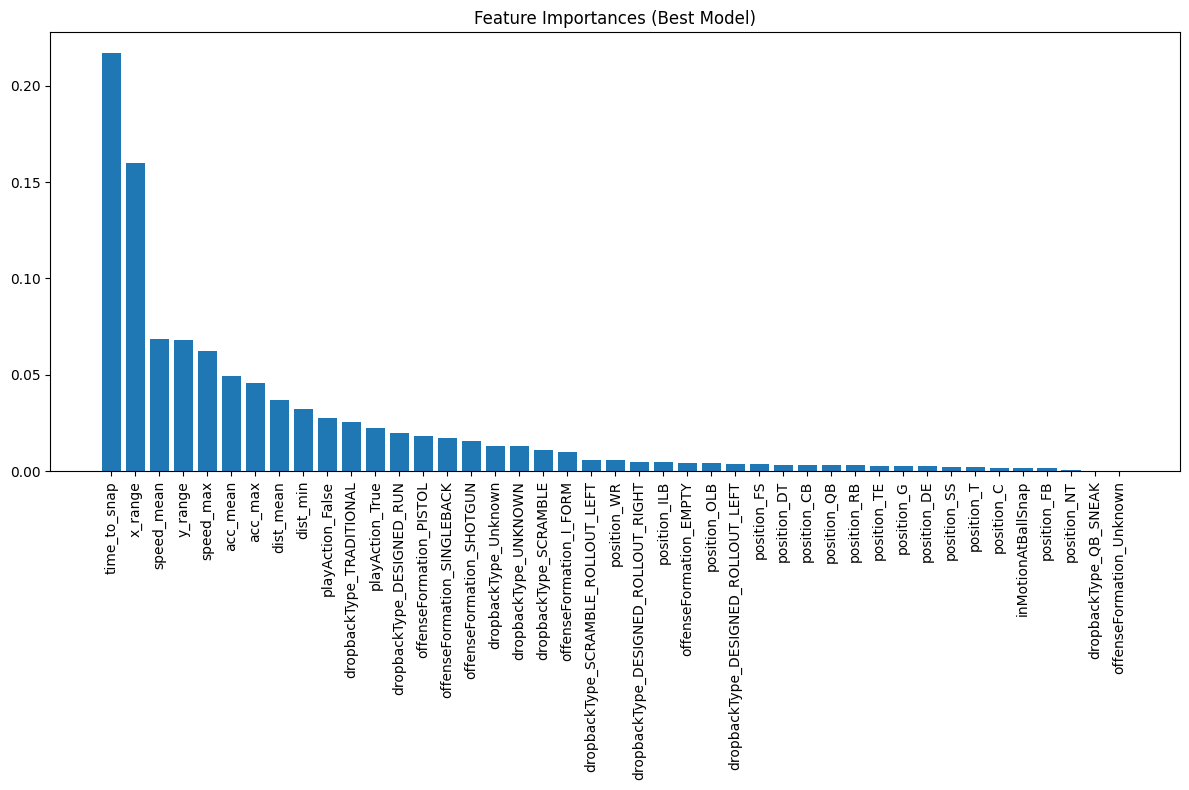


Top Cross-Validation Results:
     mean_test_score  std_test_score  \
220         0.932006        0.006513   
382         0.932006        0.006513   
332         0.930552        0.006031   
380         0.930551        0.005845   
218         0.930551        0.005845   

                                                params  
220  {'bootstrap': False, 'max_depth': None, 'max_f...  
382  {'bootstrap': False, 'max_depth': 30, 'max_fea...  
332  {'bootstrap': False, 'max_depth': 20, 'max_fea...  
380  {'bootstrap': False, 'max_depth': 30, 'max_fea...  
218  {'bootstrap': False, 'max_depth': None, 'max_f...  
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1

[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_featu

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_featur

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming agg_features_encoded and feature_columns are already defined
# Example: Replace the following with your actual dataset and feature columns
# agg_features_encoded = pd.read_csv("your_data.csv")
# feature_columns = [col for col in agg_features_encoded.columns if col not in ['bigPlay']]

# Prepare features and target variable
X = agg_features_encoded[feature_columns]
y = agg_features_encoded['bigPlay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],        # Number of features to consider for splitting
    'bootstrap': [True, False]               # Whether to bootstrap samples
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Cross-validation strategy
grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=cv, 
    n_jobs=-1, 
    verbose=2
)

# Perform the grid search
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# Output best parameters and cross-validation score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Plot feature importances of the best model
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Best Model)')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), [feature_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Cross-Validation Results
cv_results = pd.DataFrame(grid_search.cv_results_)
print("\nTop Cross-Validation Results:")
print(cv_results[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head(5))
